In [1]:
import sounddevice as sd
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
from scipy.io.wavfile import write, read
from numpy.fft import fft, ifft

# fs, rec = read('recording.wav')
fschirp, chirp = read('audio/stereochirp.wav')

In [53]:
def firfilter(sig, fs, low=None, high=None):

    if low is None:
        low = 0
    if high is None:
        high = fs/2
    
    assert(low < high)
    assert(high <= fs/2)
    assert(sig.ndim == 1)
    
    N = sig.size
    f = np.arange(N) * fs / N
    sigfft = fft(sig)
    mask = ((f>=low) & (f<=high)) | ((f>=(fs-high)) & (f<=(fs-low)))
    filtfft = np.zeros_like(sigfft)
    filtfft[mask] = sigfft[mask]
    
    return np.real(ifft(filtfft))


In [117]:
fs = 48000
sd.default.samplerate = fs
sd.default.channels = 1
duration = 10

# sd.play(chirp, fschirp)
samples = sd.rec(int(duration*fs))
sd.wait()
samples = np.squeeze(samples)

In [89]:
sd.play(samples, fs)

In [90]:
sd.stop()

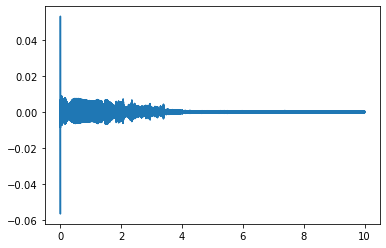

In [112]:
N = samples.size
t = np.arange(N) / fs

plt.plot(t, samples)
plt.show()

nperseg 960 noverlap 950


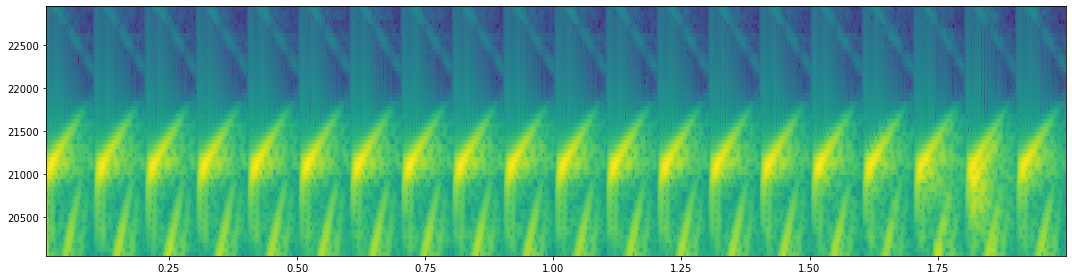

In [118]:
nperseg = fs//50
noverlap = int(nperseg*0.99)
nfft = nperseg*2
print('nperseg', nperseg, 'noverlap', noverlap)
f, t, Sxx = ss.spectrogram(samples, fs, 'hann', nperseg=nperseg, noverlap=noverlap)

fwin = (f > 20e3) & (f < 23e3)
twin = (t > 0) & (t < 2)
# fwin = (f > 300) & (f < 700)
# twin = (t > 6) & (t < 9)

plt.figure(figsize=(15,4))
plt.pcolormesh(t[twin], f[fwin], np.log(Sxx[fwin][:,twin]))
plt.tight_layout()
plt.show()

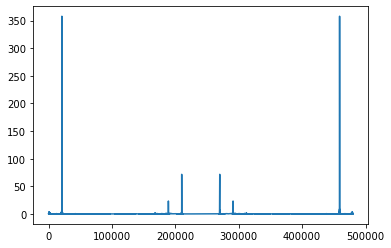

In [114]:
plt.plot(np.abs(fft(samples)))
plt.show()

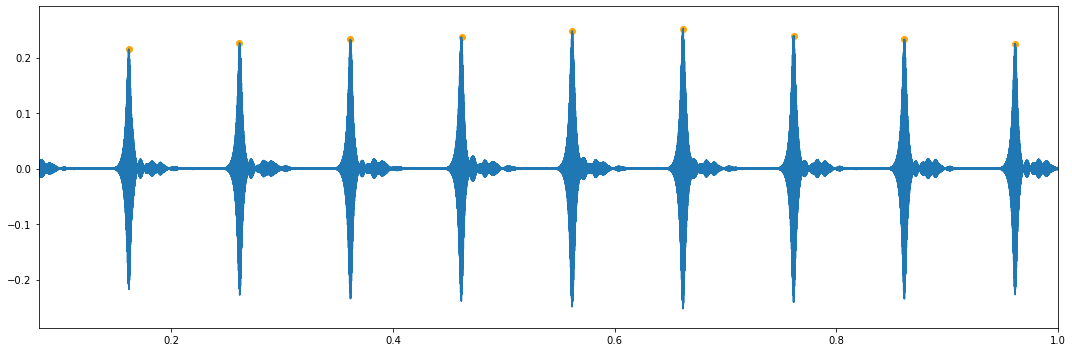

In [119]:
chirp = np.load('chirp.npy')

N = samples.size
t = np.arange(N) / fs

corr = ss.correlate(samples, chirp, mode='same')

pks, _ = ss.find_peaks(corr, distance = fs * 0.09)

plt.figure(figsize=(15,5))
plt.plot(t, corr)
plt.scatter(t[pks], corr[pks], c='orange')
plt.xlim(0.08, 1)
plt.tight_layout()
plt.show()

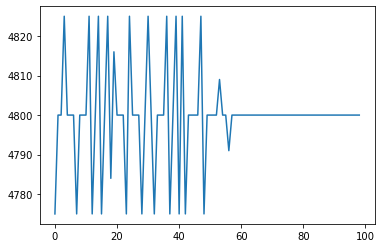

In [120]:
plt.plot(np.diff(pks))
plt.show()

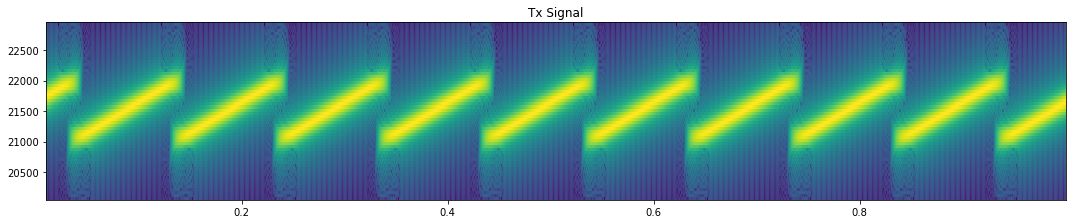

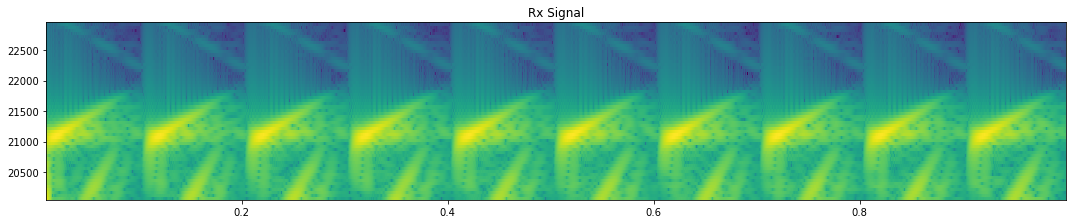

In [123]:
lotsachirps = np.tile(chirp, int(len(samples)*2/len(chirp)))
offset = pks[0]
chirps = lotsachirps[offset:len(samples)+offset]

nperseg = fs//50
noverlap = int(nperseg*0.99)
nfft = nperseg*2
f, t, X = ss.spectrogram(firfilter(chirps, fs, 20e3, 23e3), fs, 'hann', nperseg=nperseg, noverlap=noverlap)

fwin = (f > 20e3) & (f < 23e3)
twin = (t > 0) & (t < 1)
# fwin = (f > 300) & (f < 700)
# twin = (t > 6) & (t < 9)

plt.figure(figsize=(15,3))
plt.pcolormesh(t[twin], f[fwin], np.log(X[fwin][:,twin]))
plt.tight_layout()
plt.title("Tx Signal")
plt.show()

nperseg = fs//50
noverlap = int(nperseg*0.99)
nfft = nperseg*2
f, t, Y = ss.spectrogram(samples, fs, 'hann', nperseg=nperseg, noverlap=noverlap)

fwin = (f > 20e3) & (f < 23e3)
twin = (t > 0) & (t < 1)
# fwin = (f > 300) & (f < 700)
# twin = (t > 6) & (t < 9)

plt.figure(figsize=(15,3))
plt.pcolormesh(t[twin], f[fwin], np.log(Y[fwin][:,twin]))
plt.tight_layout()
plt.title("Rx Signal")
plt.show()


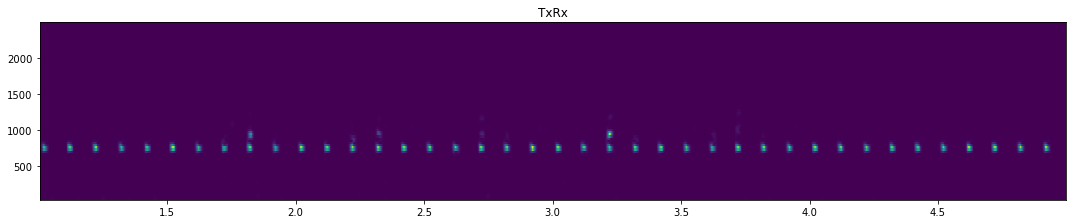

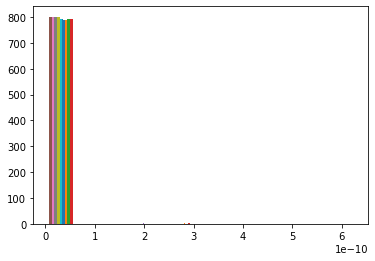

In [134]:
z = firfilter(chirps, fs, 20e3, 23e3) * firfilter(samples, fs, 20e3, 23e3)

nperseg = fs//30
noverlap = int(nperseg*0.9)
nfft = nperseg*2

f, t, Z = ss.spectrogram(z, fs, 'hann', nperseg=nperseg, noverlap=noverlap)
fwin = (f > 20e3) & (f < 25e3)
twin = (t > 1) & (t < 5)

fwin = (f > 0) & (f < 2500)
plt.figure(figsize=(15,3))
plt.pcolormesh(t[twin], f[fwin], Z[fwin][:,twin])
plt.tight_layout()
plt.title("TxRx")
plt.show()

plt.hist(Z)
plt.show()